Image dimensions: 720 x 1280
Blurring red channel...
Blurring green channel...
Blurring blue channel...


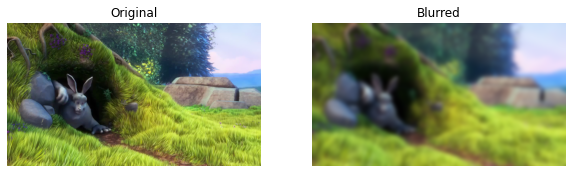


Performing Freivald's verification...
Computing rLeft @ V...
Computing H @ rRight...
Computing left side: (rLeftV @ r) @ HrRight...
Computing right side: rLeft @ r_blurred @ rRight...

Verification results:
Left side value:  40001423167893358574570136075320385596372451056081598198258416477
Right side value: 39703711791890983048527156682422442433532609584858466466755416542
Match: False

Precomputed products for Freivald's verification:
rLeftV shape: (1, 720)
HrRight shape: (1280, 1)


In [14]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Constants
bn128_scalar_modulus = 21888242871839275222246405745257275088548364400416034343698204186575808495617
KERNEL_SCALE = 2**32

def gaussian_kernel1d(sigma, radius):
    """
    Computes a 1-D Gaussian convolution kernel.
    """
    sigma2 = sigma * sigma
    x = np.arange(-radius, radius+1)
    phi_x = np.exp(-0.5 / sigma2 * x ** 2)
    phi_x = phi_x / phi_x.sum()
    return phi_x

def gaussian_kernel1d_fixed_point(sigma, radius):
    fp_kernel = gaussian_kernel1d(sigma, radius)
    return [int(x * KERNEL_SCALE) for x in fp_kernel]

def apply_horizontal_blur(image, sigma, radius, modulus):
    """
    Apply horizontal blur: Image @ H
    Instead of building H, we directly compute the result.
    """
    kernel = gaussian_kernel1d_fixed_point(sigma, radius)
    kernel_size = len(kernel)
    height, width = image.shape
    
    result = np.zeros((height, width), dtype=object)
    
    for i in range(height):
        for j in range(width):
            acc = 0
            # Apply kernel centered at position j
            for k in range(kernel_size):
                offset = k - radius
                src_idx = j + offset
                
                # Handle boundary conditions (clamp to edges)
                if src_idx < 0:
                    src_idx = 0
                elif src_idx >= width:
                    src_idx = width - 1
                
                acc = (acc + ((int(image[i, src_idx]) * kernel[k]) % modulus)) % modulus
            
            result[i, j] = acc
    
    return result

def apply_vertical_blur(image, sigma, radius, modulus):
    """
    Apply vertical blur: V @ Image
    Instead of building V, we directly compute the result.
    """
    kernel = gaussian_kernel1d_fixed_point(sigma, radius)
    kernel_size = len(kernel)
    height, width = image.shape
    
    result = np.zeros((height, width), dtype=object)
    
    for i in range(height):
        for j in range(width):
            acc = 0
            # Apply kernel centered at position i
            for k in range(kernel_size):
                offset = k - radius
                src_idx = i + offset
                
                # Handle boundary conditions (clamp to edges)
                if src_idx < 0:
                    src_idx = 0
                elif src_idx >= height:
                    src_idx = height - 1
                
                acc = (acc + ((int(image[src_idx, j]) * kernel[k]) % modulus)) % modulus
            
            result[i, j] = acc
    
    return result

def apply_horizontal_blur_to_vector(vec, sigma, radius, width, modulus):
    """
    Apply horizontal blur to a row vector: vec @ H
    vec has shape (1, width)
    """
    kernel = gaussian_kernel1d_fixed_point(sigma, radius)
    kernel_size = len(kernel)
    
    result = np.zeros((1, width), dtype=object)
    
    for j in range(width):
        acc = 0
        for k in range(kernel_size):
            offset = k - radius
            src_idx = j + offset
            
            if src_idx < 0:
                src_idx = 0
            elif src_idx >= width:
                src_idx = width - 1
            
            acc = (acc + ((int(vec[0, src_idx]) * kernel[k]) % modulus)) % modulus
        
        result[0, j] = acc
    
    return result

def apply_vertical_blur_to_vector(vec, sigma, radius, height, modulus):
    """
    Apply vertical blur to a column vector: V @ vec
    vec has shape (height, 1)
    """
    kernel = gaussian_kernel1d_fixed_point(sigma, radius)
    kernel_size = len(kernel)
    
    result = np.zeros((height, 1), dtype=object)
    
    for i in range(height):
        acc = 0
        for k in range(kernel_size):
            offset = k - radius
            src_idx = i + offset
            
            if src_idx < 0:
                src_idx = 0
            elif src_idx >= height:
                src_idx = height - 1
            
            acc = (acc + ((int(vec[src_idx, 0]) * kernel[k]) % modulus)) % modulus
        
        result[i, 0] = acc
    
    return result

def multiply_vector_matrix(vec, mat, modulus):
    """
    Multiply row vector by matrix: vec @ mat
    vec shape: (1, n), mat shape: (n, m)
    """
    assert vec.shape[1] == mat.shape[0], "Dimensions don't match"
    
    result = np.zeros((1, mat.shape[1]), dtype=object)
    
    for j in range(mat.shape[1]):
        acc = 0
        for k in range(mat.shape[0]):
            acc = (acc + ((int(vec[0, k]) * int(mat[k, j])) % modulus)) % modulus
        result[0, j] = acc
    
    return result

def multiply_matrix_vector(mat, vec, modulus):
    """
    Multiply matrix by column vector: mat @ vec
    mat shape: (m, n), vec shape: (n, 1)
    """
    assert mat.shape[1] == vec.shape[0], "Dimensions don't match"
    
    result = np.zeros((mat.shape[0], 1), dtype=object)
    
    for i in range(mat.shape[0]):
        acc = 0
        for k in range(mat.shape[1]):
            acc = (acc + ((int(mat[i, k]) * int(vec[k, 0])) % modulus)) % modulus
        result[i, 0] = acc
    
    return result

def decompose_image(file_path):
    """Load and decompose image into RGB channels"""
    img = Image.open(file_path)
    img_array = np.array(img)
    
    if len(img_array.shape) != 3 or img_array.shape[2] != 3:
        raise ValueError("The image must be in RGB format")
    
    r_channel = np.array(img_array[:, :, 0], dtype=object)
    g_channel = np.array(img_array[:, :, 1], dtype=object)
    b_channel = np.array(img_array[:, :, 2], dtype=object)
    
    return r_channel, g_channel, b_channel

# Main execution
img_path = '../demo/frames/output_0001.png'
sigma = 10.0
radius = 30

# Load image
r, g, b = decompose_image(img_path)
height, width = r.shape
print(f"Image dimensions: {height} x {width}")

# Apply blur: V @ Image @ H
print("Blurring red channel...")
r_temp = apply_horizontal_blur(r, sigma, radius, bn128_scalar_modulus)
r_blurred = apply_vertical_blur(r_temp, sigma, radius, bn128_scalar_modulus)

print("Blurring green channel...")
g_temp = apply_horizontal_blur(g, sigma, radius, bn128_scalar_modulus)
g_blurred = apply_vertical_blur(g_temp, sigma, radius, bn128_scalar_modulus)

print("Blurring blue channel...")
b_temp = apply_horizontal_blur(b, sigma, radius, bn128_scalar_modulus)
b_blurred = apply_vertical_blur(b_temp, sigma, radius, bn128_scalar_modulus)

# Convert back to image (divide by KERNEL_SCALE^2 since we applied it twice)
scale_factor = KERNEL_SCALE * KERNEL_SCALE
r_img = np.array([[int(r_blurred[i, j]) // scale_factor for j in range(width)] for i in range(height)], dtype=np.uint8)
g_img = np.array([[int(g_blurred[i, j]) // scale_factor for j in range(width)] for i in range(height)], dtype=np.uint8)
b_img = np.array([[int(b_blurred[i, j]) // scale_factor for j in range(width)] for i in range(height)], dtype=np.uint8)

# Clip values to valid range
r_img = np.clip(r_img, 0, 255)
g_img = np.clip(g_img, 0, 255)
b_img = np.clip(b_img, 0, 255)

# Display result
blurred_img = np.dstack((r_img, g_img, b_img))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
original_img = np.dstack((np.array(r, dtype=np.uint8), np.array(g, dtype=np.uint8), np.array(b, dtype=np.uint8)))
plt.imshow(original_img)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(blurred_img)
plt.title("Blurred")
plt.axis('off')
plt.show()

# Freivald's verification
print("\nPerforming Freivald's verification...")

# Generate random vectors for verification
np.random.seed(45)
freivalds_randomness_left_list = [np.random.randint(0, min(2**63, bn128_scalar_modulus)) for _ in range(height)]
freivalds_randomness_left = np.array(freivalds_randomness_left_list, dtype=object).reshape(1, -1)

freivalds_randomness_right_list = [np.random.randint(0, min(2**63, bn128_scalar_modulus)) for _ in range(width)]
freivalds_randomness_right = np.array(freivalds_randomness_right_list, dtype=object).reshape(-1, 1)

# Pre-compute random vector products with blur operations
# rLeftV is: freivalds_randomness_left @ V (a row vector)
print("Computing rLeft @ V...")
rLeftV = np.zeros((1, height), dtype=object)
kernel = gaussian_kernel1d_fixed_point(sigma, radius)
kernel_size = len(kernel)

for j in range(height):
    acc = 0
    for k in range(kernel_size):
        offset = k - radius
        i = j - offset
        if i < 0:
            i = 0
        elif i >= height:
            i = height - 1
        acc = (acc + ((int(freivalds_randomness_left[0, i]) * kernel[k]) % bn128_scalar_modulus)) % bn128_scalar_modulus
    rLeftV[0, j] = acc
# HrRight is: H @ freivalds_randomness_right (a column vector)
print("Computing H @ rRight...")
# When computing H @ rRight, each output element i is sum over j of H[i,j] * rRight[j]
# H[i,j] is non-zero when j is within kernel radius of i
HrRight = np.zeros((width, 1), dtype=object)

for i in range(width):
    acc = 0
    for k in range(kernel_size):
        offset = k - radius
        j = i + offset  # Source column index
        
        # Clamp to valid range
        if j < 0:
            j = 0
        elif j >= width:
            j = width - 1
        
        acc = (acc + ((int(freivalds_randomness_right[j, 0]) * kernel[k]) % bn128_scalar_modulus)) % bn128_scalar_modulus
    
    HrRight[i, 0] = acc

# Left side: (rLeft @ V @ r) @ (H @ rRight)
# = (rLeftV @ r) @ HrRight
print("Computing left side: (rLeftV @ r) @ HrRight...")
left_temp = multiply_vector_matrix(rLeftV, r, bn128_scalar_modulus)
left_intermediate = multiply_vector_matrix(left_temp, HrRight, bn128_scalar_modulus)

# Right side: rLeft @ r_blurred @ rRight
print("Computing right side: rLeft @ r_blurred @ rRight...")
right_temp = multiply_vector_matrix(freivalds_randomness_left, r_blurred, bn128_scalar_modulus)
right_intermediate = multiply_vector_matrix(right_temp, freivalds_randomness_right, bn128_scalar_modulus)

# Verify
print("\nVerification results:")
print(f"Left side value:  {left_intermediate[0, 0]}")
print(f"Right side value: {right_intermediate[0, 0]}")
print(f"Match: {left_intermediate[0, 0] == right_intermediate[0, 0]}")

print("\nPrecomputed products for Freivald's verification:")
print(f"rLeftV shape: {rLeftV.shape}")
print(f"HrRight shape: {HrRight.shape}")